In [196]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

[Парсер](parser.py)
[Разметка с помощью GPT](GPT.ipynb) 

Разобьем на токены и создадим словарь. Датасет предобработан так, что в нем только русский алфавит без других символов, кроме пробела, - токеном будет слово.

Модель будет nn.Embedding + nn.LSTM + nn.Linear

In [197]:
data = pd.read_csv('dataset_with_sentiments.csv')

In [198]:
# токенизация комментариев
data['Token_Comments'] = data['Comment'].str.split()

In [199]:
data

,Comment,Sentiment,Token_Comments
0,отличная компания,positive,"[отличная, компания]"
1,Никогда больше не буду работать с этой ТК,negative,"[Никогда, больше, не, буду, работать, с, этой,..."
2,все очень удобно и понятно,positive,"[все, очень, удобно, и, понятно]"
3,Людииии Хотите остаться без подарков тогда ДЛ ...,negative,"[Людииии, Хотите, остаться, без, подарков, тог..."
4,С внутренними перевозками разберитесь Деловые...,negative,"[С, внутренними, перевозками, разберитесь, Дел..."
...,...,...,...
748,Здравствуйте как так получается ВЛАДИВОСТОКС...,negative,"[Здравствуйте, как, так, получается, ВЛАДИВОСТ..."
749,Добрый день Нам пришел груз в Новосибирск Мы с...,negative,"[Добрый, день, Нам, пришел, груз, в, Новосибир..."
750,Это отвратительный сервис менеджеры никак не м...,negative,"[Это, отвратительный, сервис, менеджеры, никак..."
751,Салом алейкум всем братьям из Екатеринбурга Чк...,neutral,"[Салом, алейкум, всем, братьям, из, Екатеринбу..."


In [200]:
# создание словаря
tokens = [word for comment in data['Token_Comments'] for word in comment]
unique_tokens = set(tokens)
token_to_id = {token: id+1 for id, token in enumerate(unique_tokens)}

In [201]:
# сопоставление слову номера в словаре
def comment_to_sequence(comment):
    return [token_to_id.get(word, 0) for word in comment]

In [202]:
# переход от слов к числам
data['Token_Number_Comments'] = data['Token_Comments'].apply(comment_to_sequence)

In [203]:
# выравнивание по количеству токенов в предложении
def pad_sequence(seq, maxlen):
    if len(seq) < maxlen:
        seq += [0] * (maxlen - len(seq))
    return seq[:maxlen]

In [204]:
max_length = 50
data['Padded_Comments'] = data['Token_Number_Comments'].apply(lambda x: pad_sequence(x, max_length))

In [205]:
X_padded = np.array(data['Padded_Comments'].tolist())

In [206]:
# преобразование текстовых меток в числовые значения
sentiment_mapping = {'neutral': 0, 'negative': 1, 'positive': 2}
y = data['Sentiment'].map(sentiment_mapping).values

In [207]:
#Примеры текстов и их разбиение на токены
data

,Comment,Sentiment,Token_Comments,Token_Number_Comments,Padded_Comments
0,отличная компания,positive,"[отличная, компания]","[6749, 4290, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6749, 4290, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Никогда больше не буду работать с этой ТК,negative,"[Никогда, больше, не, буду, работать, с, этой,...","[5073, 6310, 582, 3121, 6681, 1614, 5530, 6831...","[5073, 6310, 582, 3121, 6681, 1614, 5530, 6831..."
2,все очень удобно и понятно,positive,"[все, очень, удобно, и, понятно]","[6934, 691, 6976, 2086, 5692, 0, 0, 0, 0, 0, 0...","[6934, 691, 6976, 2086, 5692, 0, 0, 0, 0, 0, 0..."
3,Людииии Хотите остаться без подарков тогда ДЛ ...,negative,"[Людииии, Хотите, остаться, без, подарков, тог...","[3950, 3322, 3621, 6458, 5135, 390, 5259, 5722...","[3950, 3322, 3621, 6458, 5135, 390, 5259, 5722..."
4,С внутренними перевозками разберитесь Деловые...,negative,"[С, внутренними, перевозками, разберитесь, Дел...","[1713, 2429, 5734, 416, 6078, 6416, 2413, 1960...","[1713, 2429, 5734, 416, 6078, 6416, 2413, 1960..."
...,...,...,...,...,...
748,Здравствуйте как так получается ВЛАДИВОСТОКС...,negative,"[Здравствуйте, как, так, получается, ВЛАДИВОСТ...","[4703, 3137, 4921, 7561, 7759, 3081, 1670, 494...","[4703, 3137, 4921, 7561, 7759, 3081, 1670, 494..."
749,Добрый день Нам пришел груз в Новосибирск Мы с...,negative,"[Добрый, день, Нам, пришел, груз, в, Новосибир...","[4077, 3211, 5274, 7781, 4059, 5722, 4997, 772...","[4077, 3211, 5274, 7781, 4059, 5722, 4997, 772..."
750,Это отвратительный сервис менеджеры никак не м...,negative,"[Это, отвратительный, сервис, менеджеры, никак...","[410, 375, 498, 6344, 2398, 582, 188, 6681, 41...","[410, 375, 498, 6344, 2398, 582, 188, 6681, 41..."
751,Салом алейкум всем братьям из Екатеринбурга Чк...,neutral,"[Салом, алейкум, всем, братьям, из, Екатеринбу...","[3717, 2105, 5924, 653, 4650, 5816, 7322, 0, 0...","[3717, 2105, 5924, 653, 4650, 5816, 7322, 0, 0..."


In [208]:
# разбиение на треин, вал и тест
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape, len(token_to_id)

((527, 50), (113, 50), (113, 50), (527,), (113,), (113,), 7883)

In [209]:
# Модель
class SentimentPredictModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.1):
        super(SentimentPredictModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(drop_prob)
        self.lin_lay_1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.lin_lay_2 = nn.Linear(hidden_dim // 2, output_dim)
        self.activation1 = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.batchnorm1(lstm_out[:, -1])
        out = self.lin_lay_1(out)
        out = self.dropout(out)
        out = self.lin_lay_2(out)
        out =  self.activation1(out)
        return out


embedding_dim = 30
hidden_dim = 80
output_dim = 3
n_layers = 1
vocab_size = len(token_to_id) + 1
model = SentimentPredictModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers)

In [210]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [211]:
batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

In [212]:
# будем пытаться обучать на видюхе
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentPredictModel(
  (embedding): Embedding(7884, 30)
  (lstm): LSTM(30, 80)
  (batchnorm1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lin_lay_1): Linear(in_features=80, out_features=40, bias=True)
  (lin_lay_2): Linear(in_features=40, out_features=3, bias=True)
  (activation1): Sigmoid()
)

In [213]:
class_weights = torch.FloatTensor([2, 1, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 1000

In [214]:
train_history = []
val_history = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # вычисление среднего тренировочного потерь
    train_loss = train_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Вычисление точности
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Вычисление среднего валидационного потерь и точности
    val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    print(f"Эпоха {epoch+1} / {n_epochs}, Тренировочные потери: {train_loss}, Валидационные потери: {val_loss}, Точность: {accuracy}%")

    train_history.append(train_loss)
    val_history.append(val_loss)

Эпоха 1 / 1000, Тренировочные потери: 1.0803022252188788, Валидационные потери: 1.088415265083313, Точность: 44.24778761061947%
Эпоха 2 / 1000, Тренировочные потери: 1.0604178110758464, Валидационные потери: 1.0754550099372864, Точность: 49.557522123893804%
Эпоха 3 / 1000, Тренировочные потери: 1.0419677098592122, Валидационные потери: 1.0656962990760803, Точность: 51.32743362831859%
Эпоха 4 / 1000, Тренировочные потери: 1.047930532031589, Валидационные потери: 1.0439475774765015, Точность: 51.32743362831859%
Эпоха 5 / 1000, Тренировочные потери: 1.0391875902811687, Валидационные потери: 1.0243728756904602, Точность: 50.442477876106196%
Эпоха 6 / 1000, Тренировочные потери: 1.0255606638060675, Валидационные потери: 1.009323239326477, Точность: 50.442477876106196%
Эпоха 7 / 1000, Тренировочные потери: 1.0182861884435017, Валидационные потери: 1.0419347286224365, Точность: 48.67256637168141%
Эпоха 8 / 1000, Тренировочные потери: 1.0218041009373136, Валидационные потери: 1.038948774337768

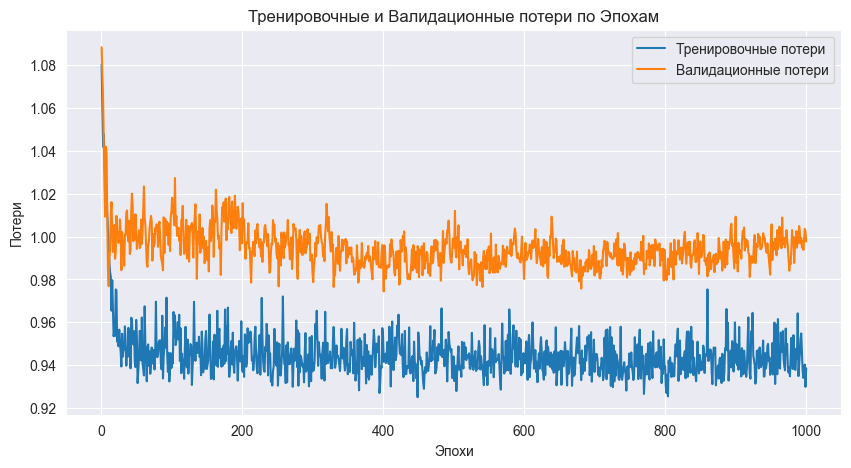

In [218]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_history, label='Тренировочные потери')
plt.plot(range(1, n_epochs + 1), val_history, label='Валидационные потери')
plt.title('Тренировочные и Валидационные потери по Эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

В принципе, переобучения не наблюдается. Есть много шума из-за dropout'а. Ошибки очень быстро выходят на плато

In [219]:
# Получение предсказаний модели
model.eval()
predictions = []
true_labels = []

test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        # Получение предсказаний
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # вычисление среднего валидационного потерь
    test_loss = test_loss / len(test_loader)

In [229]:
print(nn.Softmax(predictions))

Softmax(dim=[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [230]:
print(f"Последние валидационные потери: {val_loss}")
print(f"Последние тренировочные потери: {train_loss}")
print(f"Тестовые потери: {test_loss}")

Последние валидационные потери: 0.9977068603038788
Последние тренировочные потери: 0.9385609825452169
Тестовые потери: 0.9341045707727955


In [231]:
# Расчет метрик
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(true_labels, predictions)
precision_score = precision_score(true_labels, predictions, average="macro")
recall_score = recall_score(true_labels, predictions, average="macro")
f1_score = f1_score(true_labels, predictions, average="macro")

print(f'accuracy: {accuracy}',)
print(f'precision: {precision_score}')
print(f'recall: {recall_score}')
print(f'f1: {f1_score}')
print("Метрики, конечно не айс. В датасете сильный дизбаланс. Причем, дисбаланс классов в сторону негативных комментариев, а еще такие комментарии сильно длинее позитивных. Позитивные комментарии выглядат почти одинаково по типу: \"Все круто\". А в негативных пользователи выплескивают всю желчь. В общем негативные комментарии сильно длинее позитивных и нейтральных, да и модели сложно обучиться на 700 с лишним комментариях.")

accuracy: 0.6106194690265486
precision: 0.6493374108053007
recall: 0.36680875248650185
f1: 0.3212659999176853
Метрики, конечно не айс. В датасете сильный дизбаланс. Причем, дисбаланс классов в сторону негативных комментариев, а еще такие комментарии сильно длинее позитивных. Позитивные комментарии выглядат почти одинаково по типу: "Все круто". А в негативных пользователи выплескивают всю желчь. В общем негативные комментарии сильно длинее позитивных и нейтральных, да и модели сложно обучиться на 700 с лишним комментариях.


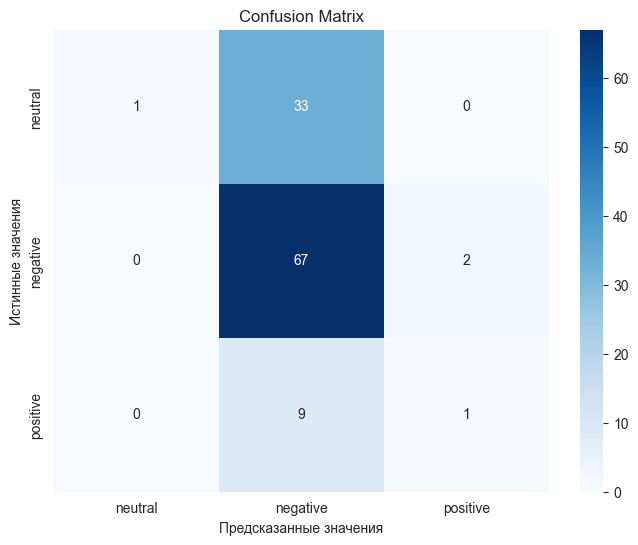

In [232]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['neutral', 'negative', 'positive'], yticklabels=['neutral', 'negative', 'positive'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Confusion Matrix')
plt.show()

In [233]:
import matplotlib.pyplot as plt
from umap import UMAP

In [234]:
embeddings = []
labels = []
model.eval()
with torch.no_grad():
    for inputs, label in test_loader:
        inputs = inputs.to(device)
        embedded = model.embedding(inputs)
        collapsed_embedding = embedded.sum(dim=1)
        embeddings.append(collapsed_embedding.cpu().numpy())
        labels.append(label.numpy())

In [235]:
# Преобразование списка эмбеддингов в массив
embeddings_array = np.array(embeddings)

In [236]:
# Reshape embeddings and labels
embeddings = np.vstack(embeddings_array)
labels = np.concatenate(labels)

In [237]:
umap = UMAP(n_components=2, random_state=42)
umap_results = umap.fit_transform(embeddings)

C:\Users\Aslan\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


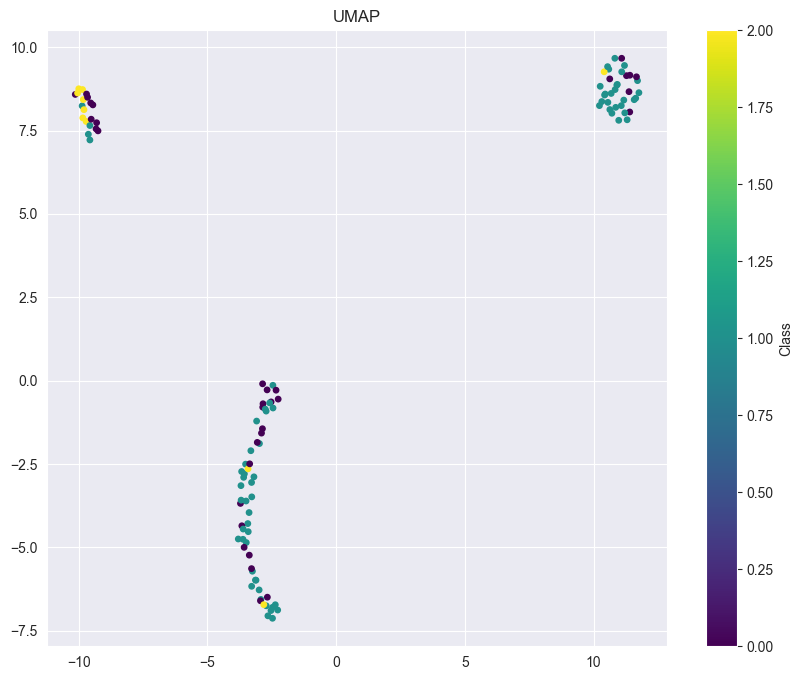

In [241]:
# Plotting the scatter plot with colors based on labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1],c=labels, s=15, cmap='viridis')
plt.title('UMAP')
plt.colorbar(scatter, label='Class')
plt.show()

Эмбеддинги в принципе разделились на три кластера, но по классам(цветам) не совсем точно получилось. Слева сверху положительные, справа отрицательные, снизу много нейтральных.

In [242]:
from IPython.display import Image
Image(url='sadlife.jpg')